In [1]:
import sys
sys.path.append('../../')
import cresthh
from cresthh import anuga
from osgeo import gdal
from glob import glob
from affine import Affine
import geopandas as gpd
from pyproj import Proj, CRS, transform
import os
import json

%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

In [19]:
from netCDF4 import Dataset

In [3]:
with open('/home/ZhiLi/mesher/examples/Houston/stream_dem/DEM_10m.mesh','r') as f:
    contents= json.loads(f.read())
    
with open('/home/ZhiLi/mesher/examples/Houston/stream_dem/DEM_10m.param','r') as f:
    params= json.loads(f.read())

In [21]:
contents['mesh'].keys()

[u'UTM_zone',
 u'proj4',
 u'outline',
 u'vertex',
 u'neigh',
 u'elem',
 u'is_geographic',
 u'nelem',
 u'nvertex']

In [22]:
from matplotlib.tri import Triangulation

In [23]:
tri= Triangulation(x=np.array(contents['mesh']['vertex'])[:,0],\
                       y=np.array(contents['mesh']['vertex'])[:,1],\
                       triangles=contents['mesh']['elem'])

In [24]:
outline= contents['mesh']['outline']

In [25]:
IDs= []
maks= np.zeros(len(tri.edges))
for coord in np.array(outline):
    iloc= np.argmin((tri.x-coord[0])**2+(tri.y-coord[1])**2)
    
    IDs.append(iloc)

In [36]:
len(IDs)

17066

In [45]:
mask1= np.isin(tri.edges[:,0], IDs)
mask2= np.isin(tri.edges[:,1], IDs)

In [46]:
mask= np.logical_and(mask1, mask2)

In [48]:
mask.sum()

19831

In [49]:
coords= []
for edge in tri.edges[mask]:
    coords.append((tri.x[edge[1]], tri.y[edge[1]]))
    coords.append((tri.x[edge[0]], tri.y[edge[0]]))

In [31]:
from shapely.geometry import LineString

In [50]:
line= LineString(coords)

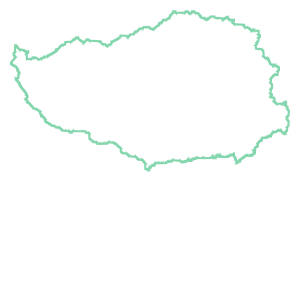

In [52]:
line

In [24]:
points_from= tri.edges[mask][:,1]
points_to= tri.edges[mask][:,0]
points_from_x= tri.x[points_from]
points_from_y= tri.y[points_from]
points_to_x= tri.x[points_to]
points_to_y= tri.y[points_to]

In [1]:
points_to_x.shape

NameError: name 'points_to_x' is not defined

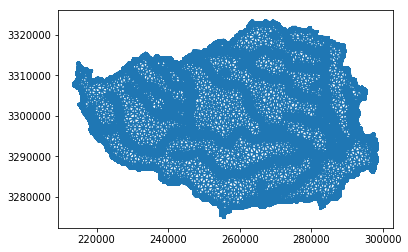

In [56]:
plt.triplot(tri)

In [53]:
points= np.array([[vert[0], vert[1]] for vert in contents['mesh']['vertex']])

In [28]:
tri= ConvexHull([[vert[0], vert[1]] for vert in contents['mesh']['vertex']])

In [31]:
points.shape

(93822, 2)

In [7]:
mesh_sample= Dataset('1km_082500.msh')

In [26]:
mesh_sample['segments'][:].shape

(6472, 2)

In [28]:
np.unique(mesh_sample['segment_tags'][:], axis=0)

array([[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       ['b', 'o', 't', 't', 'o', 'm', ' ', ' '],
       ['e', 'x', 't', 'e', 'r', 'i', 'o', 'r']], dtype='|S1')

In [34]:
mesh_sample['outline_segment_tags'][:]

masked_array(
  data=[['b', 'o', 't', 't', 'o', 'm'],
        [' ', ' ', ' ', ' ', ' ', ' '],
        [' ', ' ', ' ', ' ', ' ', ' '],
        ...,
        [' ', ' ', ' ', ' ', ' ', ' '],
        [' ', ' ', ' ', ' ', ' ', ' '],
        [' ', ' ', ' ', ' ', ' ', ' ']],
  mask=False,
  fill_value='N/A',
  dtype='|S1')

from cresthh.anuga.abstract_2d_finite_volumes.general_mesh import General_mesh

In [13]:
domain= anuga.create_domain_from_file('/home/ZhiLi/mesher/examples/Houston/stream_dem/DEM_10m.mesh')

[]


In [17]:
domain2= anuga.create_domain_from_file('1km_Houston_house_removed.msh')

[]


In [21]:
np.unique(domain2.boundary.values(),return_counts=True)

(array(['bottom', 'exterior', 'interior'], dtype='|S8'),
 array([  1, 393, 738]))

In [22]:
np.unique(domain.boundary.values(),return_counts=True)

(array(['exterior'], dtype='|S8'), array([23666]))

In [27]:
len(domain2.tag_boundary_cells['exterior'])

393

In [28]:
len(domain.tag_boundary_cells['exterior'])

23666

In [31]:
from cresthh.anuga.load_mesh.loadASCII import _read_mesh_file

In [32]:
mesh= _read_mesh_file('/home/ZhiLi/mesher/examples/Houston/stream_dem/DEM_10m.mesh')

In [40]:
mesh

{'geo_reference': (zone=-1 easting=213515.654470, northing=3274809.320004),
 'holes': array([], dtype=int64),
 'outline_segment_tags': ['exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior',
  'exterior'

Figure files for each frame will be stored in _plot


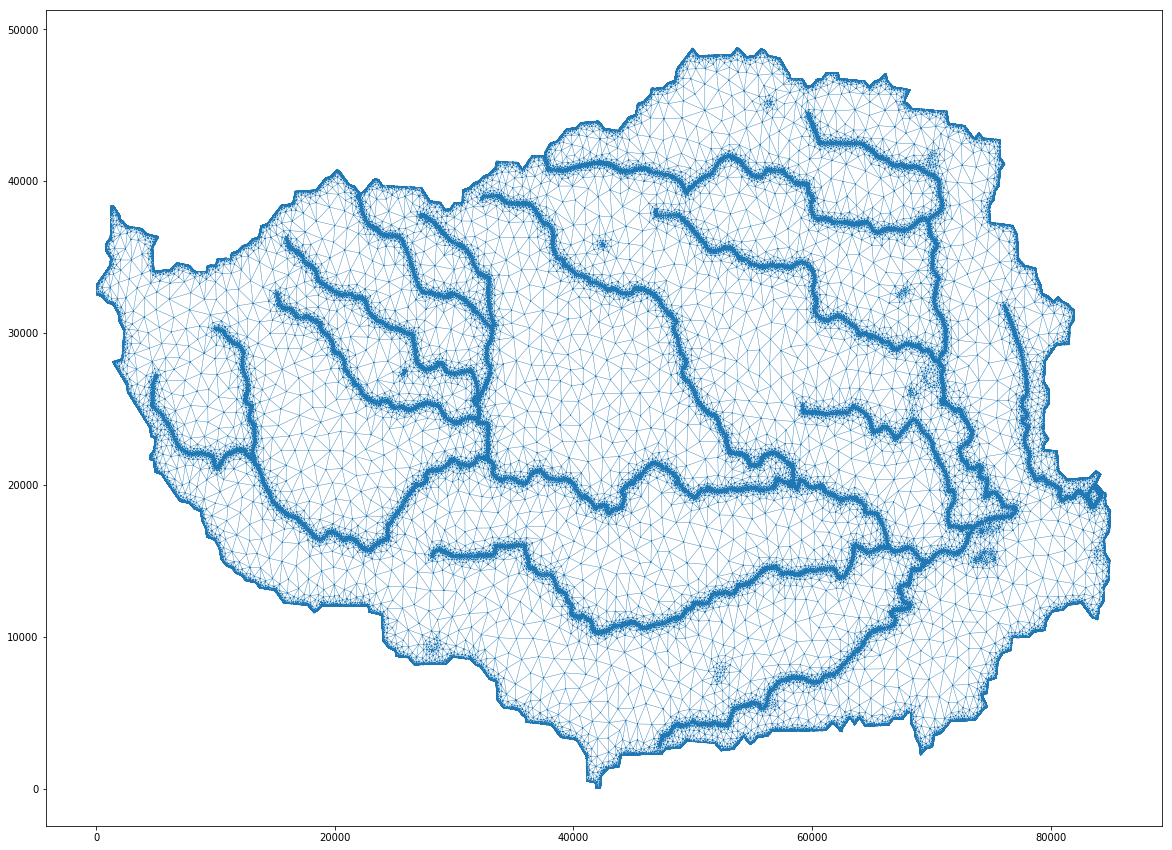

In [3]:
dplotter = anuga.Domain_plotter(domain)  
fig= plt.figure(figsize=(20,15))
plt.triplot(dplotter.triang, linewidth = 0.4);

In [4]:
print 'Number of elements:',domain.number_of_elements

Number of elements: 163976


In [5]:
topography_file = '/hydros/ZhiLi/demHouston033s_NAm83.tif'

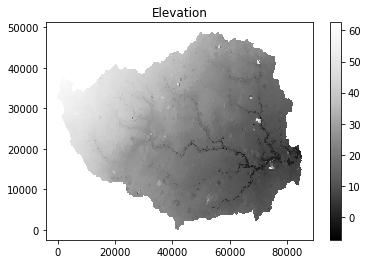

In [6]:
start= '20170825000000'
end= '20170829000000'
domain.set_proj("+proj=utm +zone=15, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
domain.set_quantity('elevation', filename=topography_file, location='centroids') # Use function for elevation
domain.set_quantity('friction', filename='/home/ZhiLi/CRESTHH/data/Texas_friction/manningn.tif', location='centroids') 
domain.set_quantity('stage', expression='elevation', location='centroids')         # Dry Bed 
domain.set_quantity('SM', 0.01, location='centroids')
domain.set_quantity('Ksat', filename='/hydros/MengyuChen/Summer/New/CREST_parameters/crest_param/ksat.tif', location='centroids')
domain.set_quantity('WM', filename='/hydros/MengyuChen/Summer/New/CREST_parameters/crest_param/wm_10m.tif', location='centroids')
domain.set_quantity('B', filename='/hydros/MengyuChen/Summer/New/CREST_parameters/crest_param/b_10m.tif', location='centroids')
domain.set_quantity('IM', filename='/hydros/MengyuChen/Summer/New/CREST_parameters/crest_param/im.tif', location='centroids')
domain.set_quantity('KE', 0.89, location='centroids')
domain.set_coupled(True)

domain.set_evap_dir('/home/ZhiLi/CRESTHH/data/evap', pattern='cov_et17%m%d.asc.tif', freq='1D')
# domain.set_precip_dir('/home/ZhiLi/CRESTHH/data/precip',pattern='nimerg%Y%m%dS%H%M%S.tif', freq='1H')
domain.set_precip_dir('/hydros/MengyuChen/mrmsPrecRate',pattern='PrecipRate_00.00_%Y%m%d-%H%M00.grib2-var0-z0.tif', freq='2M')
domain.set_timestamp(start, format='%Y%m%d%H%M%S')
domain.set_time_interval('2M')
total_seconds= (pd.to_datetime(end) - pd.to_datetime(start)).total_seconds()

plt.tripcolor(dplotter.triang, 
              facecolors = dplotter.elev, 
              cmap='Greys_r')
plt.colorbar();
plt.title("Elevation");

In [7]:
Br = anuga.Reflective_boundary(domain)
Bt = anuga.Transmissive_boundary(domain)
Bi = anuga.Dirichlet_boundary([0, 0, 0]) 

domain.set_boundary({'bottom':   Bt,
                     'interior': Br,
                     'exterior': Bi})

In [ ]:
# Rain = anuga.Quantity(domain, name='Rain')
# ET= anuga.Quantity(domain, name='ET')
# forcing_op= anuga.Rate_operator(domain, rate=Rain+ET)
# rain_op = anuga.Rate_operator(domain, rate = Rain)
# et_op = anuga.Rate_operator(domain, rate= Evap)
# Rain= anuga.Rate_operator(domain, rate=lambda t: 5 if t<5 else 10)
for i,t in enumerate(domain.evolve(yieldstep=120, duration=3600*24)):
#     current_rain_file = sorted(glob(external_dir+'/*.tif'))[i]
#     print(current_rain_file)
#     Rain.set_values_from_utm_grid_file(current_rain_file, location='centroids')
#     ET.set_values_from_utm_grid_file(current_rain_file, location='centroids')
#     dplotter.plot_depth_frame()
    dplotter.save_depth_frame(vmin=0, vmax=30)
#     domain.print_operator_timestepping_statistics()
    domain.print_timestepping_statistics(track_speeds=False)
#     domain.report_water_volume_statistics()

    stage = domain.get_quantity('stage')
    elev  = domain.get_quantity('elevation')
    height = stage - elev
    print 'integral = ', height.get_integral()    
# Read in the png files stored during the evolve loop
dplotter.make_depth_animation()

evolving elements: 163976
Time = 2017-08-25 00:00:00, steps=0 (38s)
integral =  0.0
Time = 2017-08-25 00:02:00, delta t in [1.02402641, 1.47774373], steps=112 (17s)
integral =  14876.06130662645
Time = 2017-08-25 00:04:00, delta t in [1.08649119, 1.08801210], steps=111 (17s)
integral =  26651.372197279856
Time = 2017-08-25 00:06:00, delta t in [0.60890967, 1.08913404], steps=155 (21s)
integral =  37502.914410379206
Time = 2017-08-25 00:08:00, delta t in [0.60428068, 0.60961622], steps=199 (25s)
integral =  47828.82158633728
Time = 2017-08-25 00:10:00, delta t in [0.60962802, 0.62986945], steps=194 (25s)
integral =  57708.096606872285
Time = 2017-08-25 00:12:00, delta t in [0.62997645, 0.66096237], steps=187 (24s)
integral =  67100.14213988875
Time = 2017-08-25 00:14:00, delta t in [0.66104037, 0.71047523], steps=176 (23s)
integral =  76075.56111780285
Time = 2017-08-25 00:16:00, delta t in [0.71048290, 0.73694950], steps=166 (22s)
integral =  84745.58980890289
Time = 2017-08-25 00:18:0